### Check GPU Support

In [1]:
import tensorflow as tf

# Check GPU (Metal) support
print(f"Metal GPU support: {'Yes' if tf.config.list_physical_devices('GPU') else 'No'}")

# List available devices
devices = tf.config.list_physical_devices()
print("\nDetected devices:")
for device in devices:
    print(f"- {device}")

# Run test operation on GPU
try:
    with tf.device('/GPU:0'):
        a = tf.random.normal([2000, 2000])
        b = tf.random.normal([2000, 2000])
        
        print("\nPerforming test operation on GPU...")
        c = tf.matmul(a, b)
        
    print("\n✅ Operation completed using Metal GPU!")
    print(f"Result shape: {c.shape}")
    print(f"Device used: {c.device}")

except Exception as e:
    print("\n❌ Error using GPU:", e)


/Users/santiago/School/tc3002b/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Metal GPU support: Yes

Detected devices:
- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Performing test operation on GPU...

✅ Operation completed using Metal GPU!
Result shape: (2000, 2000)
Device used: /job:localhost/replica:0/task:0/device:GPU:0


2025-04-28 13:32:21.517380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-28 13:32:21.517401: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-28 13:32:21.517405: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-28 13:32:21.517424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 13:32:21.517433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Check Data

=== DATASET EXPLORATION ===

Exploring directory: ./dataset/train
Found classes: ['clubs', 'spades', 'diamonds', 'hearts']
  - Class 'clubs': 1806 images, average dimensions: 224.0x224.0
  - Class 'spades': 2031 images, average dimensions: 224.0x224.0
  - Class 'diamonds': 1827 images, average dimensions: 224.0x224.0
  - Class 'hearts': 1845 images, average dimensions: 224.0x224.0
Total number of images: 7509

Exploring directory: ./dataset/test
Found classes: ['clubs', 'spades', 'diamonds', 'hearts']
  - Class 'clubs': 65 images, average dimensions: 224.0x224.0
  - Class 'spades': 65 images, average dimensions: 224.0x224.0
  - Class 'diamonds': 65 images, average dimensions: 224.0x224.0
  - Class 'hearts': 65 images, average dimensions: 224.0x224.0
Total number of images: 260

Statistics saved to: results/dataset_stats.json


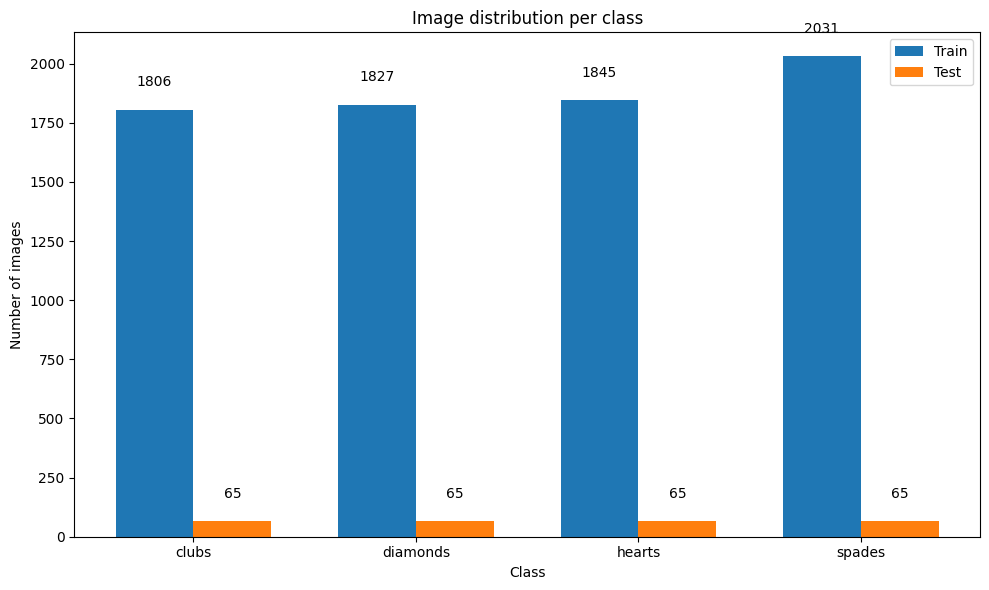

In [2]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import json

# Configuration
from config import TRAIN_DIR, TEST_DIR, RESULTS_DIR

os.makedirs(RESULTS_DIR, exist_ok=True)

def explore_dataset(base_dir):
    print(f"\nExploring directory: {base_dir}")
    
    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    print(f"Found classes: {classes}")
    
    # Count of images per class
    stats = {}
    total_images = 0
    dimensions_by_class = {}
    
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) 
                 and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        num_images = len(images)
        stats[cls] = num_images
        total_images += num_images
        
        # Get dimension info from a few sample images
        if num_images > 0:
            sample_imgs = random.sample(images, min(5, num_images))
            dimensions = []
            
            for img_file in sample_imgs:
                img_path = os.path.join(class_dir, img_file)
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)
                except Exception as e:
                    print(f"Error opening {img_path}: {e}")
            
            if dimensions:
                avg_width = sum(d[0] for d in dimensions) / len(dimensions)
                avg_height = sum(d[1] for d in dimensions) / len(dimensions)
                dimensions_by_class[cls] = {"avg_width": avg_width, "avg_height": avg_height}
                print(f"  - Class '{cls}': {num_images} images, average dimensions: {avg_width:.1f}x{avg_height:.1f}")
            else:
                print(f"  - Class '{cls}': {num_images} images")
    
    print(f"Total number of images: {total_images}")
    
    # Include dimension info in the statistics
    stats_complete = {
        "counts": stats,
        "dimensions": dimensions_by_class,
        "total_images": total_images,
        "classes": classes
    }
    
    return stats_complete

print("=== DATASET EXPLORATION ===")

# Training data
train_stats = explore_dataset(TRAIN_DIR)

# Test data
test_stats = explore_dataset(TEST_DIR)

# Save statistics for later use
dataset_stats = {
    "train": train_stats,
    "test": test_stats
}

# Save the statistics as JSON for future reference
stats_path = os.path.join(RESULTS_DIR, "dataset_stats.json")
with open(stats_path, 'w') as f:
    json.dump(dataset_stats, f, indent=4)
print(f"\nStatistics saved to: {stats_path}")

# Class distribution
if train_stats and test_stats:
    
    # Create comparative bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    all_classes = sorted(set(train_stats["classes"] + test_stats["classes"]))
    
    train_counts = [train_stats["counts"].get(cls, 0) for cls in all_classes]
    test_counts = [test_stats["counts"].get(cls, 0) for cls in all_classes]
    
    x = np.arange(len(all_classes))
    width = 0.35
    
    ax.bar(x - width/2, train_counts, width, label='Train')
    ax.bar(x + width/2, test_counts, width, label='Test')
    
    ax.set_title('Image distribution per class')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of images')
    ax.set_xticks(x)
    ax.set_xticklabels(all_classes)
    ax.legend()
    
    for i, v in enumerate(train_counts):
        ax.text(i - width/2, v + 100, str(v), ha='center')
    
    for i, v in enumerate(test_counts):
        ax.text(i + width/2, v + 100, str(v), ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "class_distribution.png"), dpi=300)
    plt.show()


### Process Data

Found 6008 images belonging to 4 classes.
Found 52 images belonging to 4 classes.
Found 260 images belonging to 4 classes.

Data generator statistics:
- Class encoding vector: {'clubs': 0, 'diamonds': 1, 'hearts': 2, 'spades': 3}
- Training: 6008 instances
- Steps per epoch (train): 188 iterations
- Validation: 52 instances
- Steps per epoch (val): 2 iterations
- Test: 260 instances
- Steps for evaluation: 9 iterations

Input tensor structure: (32, 224, 224, 3)
Label tensor structure: (32, 4)
Value range after normalization: [0.0, 1.0]


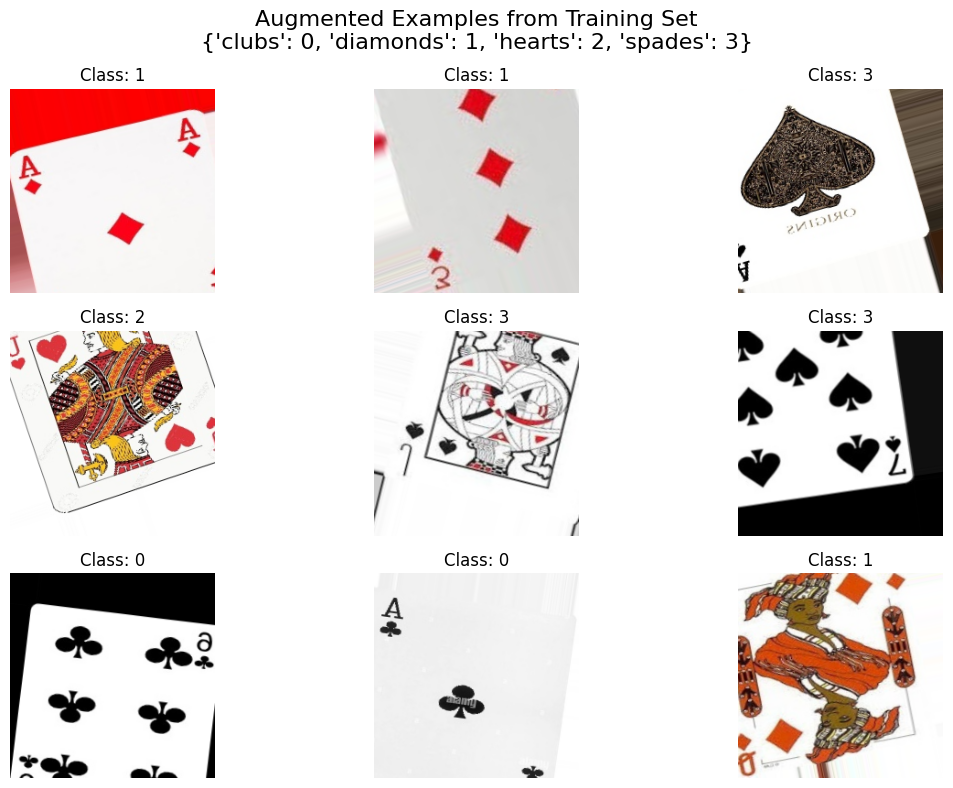

(array([[[[0.9758286 , 0.01112262, 0.01504419],
          [0.97011065, 0.01176471, 0.00932628],
          [0.97170806, 0.01176471, 0.00784314],
          ...,
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ]],
 
         [[0.97495085, 0.01024491, 0.01416648],
          [0.9718661 , 0.01176471, 0.0110817 ],
          [0.9708303 , 0.01176471, 0.00784314],
          ...,
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ]],
 
         [[0.9740732 , 0.0093672 , 0.01328877],
          [0.9736215 , 0.01176471, 0.01283712],
          [0.96995264, 0.01176471, 0.00784314],
          ...,
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ],
          [0.98823535, 0.01176471, 0.        ]],
 
         ...,
 
         [[0.87234056, 0.6313726 , 0.64747596],
          [0.87146

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Import configuration
from config import (
    TRAIN_DIR, TEST_DIR, VALID_DIR, RESULTS_DIR, 
    IMG_SIZE, BATCH_SIZE, 
    ROTATION_RANGE, WIDTH_SHIFT_RANGE, HEIGHT_SHIFT_RANGE, 
    HORIZONTAL_FLIP, VALIDATION_SPLIT
)


def create_data_generators():
    """
    Creates and configures data generators for training, validation and testing.
    
    Returns:
        tuple: (train_generator, validation_generator, test_generator)
    """
    
    # Preprocessing pipeline configuration with data augmentation techniques
    train_datagen = ImageDataGenerator(
        
        # Min-max normalization to scale pixel values to range [0,1]
        rescale=1./255,  
        
        # Data augmentation techniques
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        
        # internal cross-validation
        validation_split=VALIDATION_SPLIT,
    )

    # For the test set we only apply normalization
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generator for the training subset with data augmentation
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
    )

    # Generator for internal validation during training (early stopping)
    validation_generator = train_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
    )

    # Generator for final evaluation on test set
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

# Analyze and save information about the data generators
def analyze_generators(train_generator, validation_generator, test_generator):
    """
    Analyzes and saves information about the data generators.
    
    Args:
        train_generator: Training data generator
        validation_generator: Validation data generator
        test_generator: Test data generator
    """
    # Analysis of the resulting configuration
    generators_info = {
        "class_indices": train_generator.class_indices,
        "train_samples": train_generator.samples,
        "train_steps_per_epoch": len(train_generator),
        "validation_samples": validation_generator.samples,
        "validation_steps": len(validation_generator),
        "test_samples": test_generator.samples,
        "test_steps": len(test_generator),
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE
    }
    
    # Save information for use in later scripts
    with open(os.path.join(RESULTS_DIR, "generators_info.json"), "w") as f:
        json.dump(generators_info, f, indent=4)
    
    print("\nData generator statistics:")
    print(f"- Class encoding vector: {train_generator.class_indices}")
    print(f"- Training: {train_generator.samples} instances")
    print(f"- Steps per epoch (train): {len(train_generator)} iterations")
    print(f"- Validation: {validation_generator.samples} instances")
    print(f"- Steps per epoch (val): {len(validation_generator)} iterations")
    print(f"- Test: {test_generator.samples} instances")
    print(f"- Steps for evaluation: {len(test_generator)} iterations")
    
    return generators_info

# Function to safely obtain and visualize a batch
def visualize_batch(train_generator, max_attempts=3):
    """
    Safely obtains and visualizes a batch from the data generator.
    
    Args:
        train_generator: Training data generator
        max_attempts: Maximum number of attempts to get a batch
        
    Returns:
        tuple: (batch_x, batch_y) or (None, None) if there's an error
    """
    for attempt in range(max_attempts):
        try:
            batch_x, batch_y = next(train_generator)
            
            if len(batch_x) > 0:
                print(f"\nInput tensor structure: {batch_x.shape}")
                print(f"Label tensor structure: {batch_y.shape}")
                print(f"Value range after normalization: [{batch_x.min()}, {batch_x.max()}]")

                # Visualization of data augmentation examples
                plt.figure(figsize=(12, 8))
                for i in range(min(9, batch_x.shape[0])):
                    plt.subplot(3, 3, i+1)
                    plt.imshow(batch_x[i])
                    plt.title(f"Class: {np.argmax(batch_y[i])}")
                    plt.axis('off')

                plt.suptitle(f"Augmented Examples from Training Set\n{train_generator.class_indices}", fontsize=16)
                plt.tight_layout()
                plt.savefig(os.path.join(RESULTS_DIR, "batch_examples.png"), dpi=300)
                plt.show()
                
                return batch_x, batch_y
        
        except Exception as e:
            print(f"Error getting batch (attempt {attempt+1}/{max_attempts}): {e}")
            if attempt == max_attempts - 1:
                print("Could not obtain examples for visualization.")
                return None, None

# Create and analyze data generators
train_generator, validation_generator, test_generator = create_data_generators()

# Analyze and save information about the generators
analyze_generators(train_generator, validation_generator, test_generator)

# Visualize a sample batch
visualize_batch(train_generator)

### Model 22 - Apr

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 #type: ignore
from tensorflow.keras import layers, models, optimizers #type: ignore
import os
import json
import numpy as np

# Importar configuración
from config import (
    IMG_SIZE, LEARNING_RATE, DROPOUT_RATE, 
    MODEL_PATH, MODEL_DIR
)

# Config Parameters
# LEARNING_RATE = 1e-4  # Tasa de aprendizaje inicial
# FINI_TUNING_LR = 1e-5  # Tasa de aprendizaje inicial
# DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# # Hiperparámetros de entrenamiento
# EPOCHS = 30  # Número de épocas máximas
# PATIENCE = 12  # Épocas para early stopping

def crear_modelo_cnn_mejorado():
    """
    Implementa una arquitectura CNN mediante transfer learning con ResNet50.
    Incluye mejoras para reducir overfitting y mejorar la generalización.
    
    Returns:
        Modelo compilado listo para entrenamiento
    """
    print("Inicializando arquitectura CNN mejorada con transfer learning...")
    
    # Cargar modelo base preentrenado (backbone) sin capas de clasificación
    modelo_base = ResNet50(
        weights='imagenet',    # Inicialización con pesos preentrenados en ImageNet
        include_top=False,     # Excluir capas fully-connected superiores
        input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Dimensiones de entrada: HxWxC
    )
    
    # Congelar pesos del backbone para evitar catástrofe de olvido
    # Solo dejamos entrenar las últimas 15 capas para fine-tuning
    for layer in modelo_base.layers[:-15]:
        layer.trainable = False
        
    print(f"Base parcialmente congelada: {modelo_base.name}")
    print(f"Capas entrenables: {len([l for l in modelo_base.layers if l.trainable])}/{len(modelo_base.layers)}")
    
    # Construir arquitectura completa mejorada
    modelo = models.Sequential([
        modelo_base,
        
        layers.GlobalAveragePooling2D(),
        
        # Primera capa densa con batch normalization para estabilizar el entrenamiento
        layers.Dense(512, use_bias=False),  # Sin bias antes de batch norm
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(DROPOUT_RATE),
        
        # Segunda capa densa también con regularización
        layers.Dense(256, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(DROPOUT_RATE/2),

        # Tercera capa densa con activación ReLU
        layers.Dense(128, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(DROPOUT_RATE/4),

        # Capa de salida para clasificación binaria con activación sigmoide
        layers.Dense(4, activation='softmax')
    ])
    
    # Compilar modelo definiendo función de pérdida, optimizador y métricas
    modelo.compile(
        # Optimizador adaptativo con learning rate dinámico
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        
        # categorical_crossentropy: función de pérdida estándar para clasificación
        loss='categorical_crossentropy',
        
        # Métricas para monitorizar durante entrenamiento y evaluación
        metrics=[
            'accuracy',  # Precisión global: (TP+TN)/(TP+TN+FP+FN)
            tf.keras.metrics.AUC(),  # Área bajo la curva ROC
            tf.keras.metrics.Precision(),  # Precisión: TP/(TP+FP)
            tf.keras.metrics.Recall()  # Recall (sensibilidad): TP/(TP+FN)
        ]
    )
    
    return modelo

# Asegurar que el directorio existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Crear la arquitectura del modelo mejorado
modelo = crear_modelo_cnn_mejorado()

# Visualizar resumen de la arquitectura
print("\nArquitectura del modelo CNN mejorado:")
modelo.summary()

# Intentar guardar el diagrama del modelo para referencia
try:
    tf.keras.utils.plot_model(
        modelo, 
        to_file=os.path.join(MODEL_DIR, 'model_architecture.png'),
        show_shapes=True, 
        show_dtype=True, 
        show_layer_names=True
    )
    print(f"Diagrama del modelo guardado en: {os.path.join(MODEL_DIR, 'model_architecture.png')}")
except ImportError:
    print("No se pudo generar el diagrama del modelo. Se requiere instalar graphviz correctamente.")

# Guardar arquitectura inicial en formato moderno .keras
modelo.save(MODEL_PATH)
print(f"\nArquitectura mejorada guardada en: {MODEL_PATH}")

# Guardar también la estructura como JSON para referencia
trainable_params = int(sum(tf.keras.backend.count_params(p) for p in modelo.trainable_weights))
non_trainable_params = int(sum(tf.keras.backend.count_params(p) for p in modelo.non_trainable_weights))

model_config = {
    "num_layers": len(modelo.layers),
    "params": int(modelo.count_params()),
    "trainable_params": trainable_params,
    "non_trainable_params": non_trainable_params,
}

with open(os.path.join(MODEL_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f, indent=4)

print("\nPrincipales características del modelo:")
print("1. Transfer learning con ResNet50 preentrenado")
print("2. Fine-tuning de las últimas capas para adaptación al problema específico")
print("3. Batch normalization para estabilizar el entrenamiento")
print(f"4. Alto dropout ({DROPOUT_RATE}) para reducir overfitting")
print("5. Estructura multi-capa con regularización")

Inicializando arquitectura CNN mejorada con transfer learning...
Base parcialmente congelada: resnet50
Capas entrenables: 15/175

Arquitectura del modelo CNN mejorado:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,804,228 (94.62 MB)

 Trainable params: 6,735,108 (25.69 MB)

 Non-trainable params: 18,069,120 (68.93 MB)

Diagrama del modelo guardado en: models/model_architecture.png

Arquitectura mejorada guardada en: models/modelo_detector.keras

Principales características del modelo:
1. Transfer learning con ResNet50 preentrenado
2. Fine-tuning de las últimas capas para adaptación al problema específico
3. Batch normalization para estabilizar el entrenamiento
4. Alto dropout (0.3) para reducir overfitting
5. Estructura multi-capa con regularización


### Model 25 Apr

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 #type: ignore
from tensorflow.keras import layers, models, optimizers #type: ignore
import os
import json
import numpy as np

# Importar configuración
from config import (
    IMG_SIZE, LEARNING_RATE, DROPOUT_RATE, 
    MODEL_PATH, MODEL_DIR
)

# Config Parameters
# LEARNING_RATE = 1e-4  # Tasa de aprendizaje inicial
# FINI_TUNING_LR = 1e-5  # Tasa de aprendizaje inicial
# DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# # Hiperparámetros de entrenamiento
# EPOCHS = 10  # Número de épocas máximas
# PATIENCE = 5  # Épocas para early stopping

def crear_modelo_cnn_mejorado():
    """
    Implementa una arquitectura CNN mediante transfer learning con ResNet50.
    Incluye mejoras para reducir overfitting y mejorar la generalización.
    
    Returns:
        Modelo compilado listo para entrenamiento
    """
    print("Inicializando arquitectura CNN mejorada con transfer learning...")
    
    # Cargar modelo base preentrenado (backbone) sin capas de clasificación
    modelo_base = ResNet50(
        weights='imagenet',    # Inicialización con pesos preentrenados en ImageNet
        include_top=False,     # Excluir capas fully-connected superiores
        input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Dimensiones de entrada: HxWxC
    )
    
    # Construir arquitectura completa mejorada
    modelo = models.Sequential([
        modelo_base,
        
        layers.GlobalAveragePooling2D(),
        
        # Primera capa densa con batch normalization para estabilizar el entrenamiento
        layers.Dense(512, use_bias=False),  # Sin bias antes de batch norm
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(DROPOUT_RATE),
        
        # Segunda capa densa también con regularización
        layers.Dense(256, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(DROPOUT_RATE/2),

        # Capa de salida para clasificación binaria con activación sigmoide
        layers.Dense(4, activation='softmax')
    ])
    
    # Compilar modelo definiendo función de pérdida, optimizador y métricas
    modelo.compile(
        # Optimizador adaptativo con learning rate dinámico
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        
        # categorical_crossentropy: función de pérdida estándar para clasificación
        loss='categorical_crossentropy',
        
        # Métricas para monitorizar durante entrenamiento y evaluación
        metrics=[
            'accuracy',  # Precisión global: (TP+TN)/(TP+TN+FP+FN)
            tf.keras.metrics.AUC(),  # Área bajo la curva ROC
            tf.keras.metrics.Precision(),  # Precisión: TP/(TP+FP)
            tf.keras.metrics.Recall()  # Recall (sensibilidad): TP/(TP+FN)
        ]
    )
    
    return modelo

# Asegurar que el directorio existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Crear la arquitectura del modelo mejorado
modelo = crear_modelo_cnn_mejorado()

# Visualizar resumen de la arquitectura
print("\nArquitectura del modelo CNN mejorado:")
modelo.summary()

# Intentar guardar el diagrama del modelo para referencia
try:
    tf.keras.utils.plot_model(
        modelo, 
        to_file=os.path.join(MODEL_DIR, 'model_architecture.png'),
        show_shapes=True, 
        show_dtype=True, 
        show_layer_names=True
    )
    print(f"Diagrama del modelo guardado en: {os.path.join(MODEL_DIR, 'model_architecture.png')}")
except ImportError:
    print("No se pudo generar el diagrama del modelo. Se requiere instalar graphviz correctamente.")

# Guardar arquitectura inicial en formato moderno .keras
modelo.save(MODEL_PATH)
print(f"\nArquitectura mejorada guardada en: {MODEL_PATH}")

# Guardar también la estructura como JSON para referencia
trainable_params = int(sum(tf.keras.backend.count_params(p) for p in modelo.trainable_weights))
non_trainable_params = int(sum(tf.keras.backend.count_params(p) for p in modelo.non_trainable_weights))

model_config = {
    "num_layers": len(modelo.layers),
    "params": int(modelo.count_params()),
    "trainable_params": trainable_params,
    "non_trainable_params": non_trainable_params,
}

with open(os.path.join(MODEL_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f, indent=4)

print("\nPrincipales características del modelo:")
print("1. Transfer learning con ResNet50 preentrenado")
print("2. Fine-tuning de las últimas capas para adaptación al problema específico")
print("3. Batch normalization para estabilizar el entrenamiento")
print(f"4. Alto dropout ({DROPOUT_RATE}) para reducir overfitting")
print("5. Estructura multi-capa con regularización")

Inicializando arquitectura CNN mejorada con transfer learning...

Arquitectura del modelo CNN mejorado:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,771,460 (94.50 MB)

 Trainable params: 24,716,804 (94.29 MB)

 Non-trainable params: 54,656 (213.50 KB)

Diagrama del modelo guardado en: models/model_architecture.png

Arquitectura mejorada guardada en: models/modelo_detector.keras

Principales características del modelo:
1. Transfer learning con ResNet50 preentrenado
2. Fine-tuning de las últimas capas para adaptación al problema específico
3. Batch normalization para estabilizar el entrenamiento
4. Alto dropout (0.3) para reducir overfitting
5. Estructura multi-capa con regularización


### Training

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import shutil
import json
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, Callback # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import traceback # Import traceback for better error reporting

try:
    from config import (
        MODEL_PATH, BEST_MODEL_PATH,
        LOGS_DIR, RESULTS_DIR, BACKUP_DIR, MODEL_NAME,
        EPOCHS, PATIENCE, CLASS_NAMES
    )
except ImportError:
    print("ERROR: Could not import configuration from config.py.")
    print("Please ensure config.py exists and contains the required variables.")
    exit()


class BackupCallback(Callback):
    """Callback to backup the model during training"""
    def __init__(self, checkpoint_filepath, backup_dir, backup_frequency=3):
        super().__init__()
        self.checkpoint_filepath = checkpoint_filepath
        self.backup_dir = backup_dir
        self.backup_frequency = backup_frequency
        # Ensure backup directory exists
        os.makedirs(self.backup_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # Create backup every N epochs, check if the *best* model file exists
        if (epoch + 1) % self.backup_frequency == 0 and os.path.exists(self.checkpoint_filepath):
            backup_path = os.path.join(
                self.backup_dir,
                f"model_backup_epoch_{epoch+1}.keras"
            )
            try:
                shutil.copy(self.checkpoint_filepath, backup_path)
                print(f"\nBackup of best model so far created at: {backup_path}")
            except Exception as e:
                print(f"\nWarning: Could not create backup at epoch {epoch+1}: {e}")


def create_callbacks():
    """
    Configure callbacks for model training

    Returns:
        list: List of configured callbacks
    """
    print("\nConfiguring callbacks for monitoring and regularization...")

    # Ensure necessary directories exist
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(BACKUP_DIR, exist_ok=True)
    os.makedirs(os.path.join(LOGS_DIR, MODEL_NAME), exist_ok=True)

    # Path to save the best model based on validation accuracy
    best_model_path_acc = BEST_MODEL_PATH # From config

    # Path to save the best model based on validation loss
    best_model_path_loss = os.path.join(RESULTS_DIR, f'{MODEL_NAME}_best_loss.keras')

    callbacks = [
        # Save model with best validation performance (criteria: accuracy)
        ModelCheckpoint(
            filepath=best_model_path_acc,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),

        # Also save model with best loss (may differ from best accuracy)
        ModelCheckpoint(
            filepath=best_model_path_loss,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),

        # Early stopping to halt training when performance plateaus
        EarlyStopping(
            monitor='val_loss', # Stop based on validation loss
            patience=PATIENCE,
            restore_best_weights=True, # Restore weights from the epoch with the best val_loss
            verbose=1
        ),

        # Periodically save backup of the best accuracy model
        BackupCallback(best_model_path_acc, BACKUP_DIR),

        # Reduce learning rate when learning stagnates
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,       # Reduce LR by half
            patience=PATIENCE // 2 if PATIENCE // 2 >= 1 else 1, # Reduce LR faster than stopping
            min_lr=1e-6,
            verbose=1
        ),

        # TensorBoard for training process visualization
        TensorBoard(
            log_dir=os.path.join(LOGS_DIR, MODEL_NAME),
            histogram_freq=1
        )
    ]

    return callbacks


# Modify your training function to avoid distributed strategy issues:
def train_model(model, train_generator, validation_generator):
    """Train the model using the provided data generators"""
    # Configure callbacks
    callbacks = create_callbacks()

    # Model training
    print("\nStarting training...")
    start_time = time.time()

    print("Training on available hardware...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    print("\n✓ Training completed.")

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    hours, rem = divmod(training_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Training time: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

    return history


def visualize_learning_curves(history):
    """
    Generate and save learning curve plots

    Args:
        history: Model training history
    """
    print("\nGenerating learning curve visualizations...")

    # Ensure results directory exists
    os.makedirs(RESULTS_DIR, exist_ok=True)

    # Create figure for learning curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Training History: {MODEL_NAME}', fontsize=16)

    # --- Plot 1: Accuracy ---
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].legend(loc='lower right')
        axes[0, 0].grid(True, linestyle='--', alpha=0.6)
    else:
         axes[0, 0].set_title('Accuracy Plot Unavailable')
         axes[0, 0].text(0.5, 0.5, 'Accuracy metrics not found in history', horizontalalignment='center', verticalalignment='center')


    # --- Plot 2: Loss ---
    if 'loss' in history.history and 'val_loss' in history.history:
        axes[0, 1].plot(history.history['loss'], label='Training Loss')
        axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_ylabel('Loss Value')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].legend(loc='upper right')
        axes[0, 1].grid(True, linestyle='--', alpha=0.6)
    else:
         axes[0, 1].set_title('Loss Plot Unavailable')
         axes[0, 1].text(0.5, 0.5, 'Loss metrics not found in history', horizontalalignment='center', verticalalignment='center')


    # --- Plot 3: AUC (if available) ---
    auc_key = next((k for k in history.history if 'auc' in k and 'val_' not in k), None)
    val_auc_key = next((k for k in history.history if 'auc' in k and 'val_' in k), None)

    if auc_key and val_auc_key:
        axes[1, 0].plot(history.history[auc_key], label=f'Training {auc_key.upper()}')
        axes[1, 0].plot(history.history[val_auc_key], label=f'Validation {auc_key.upper()}')
        axes[1, 0].set_title('Model AUC')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].legend(loc='lower right')
        axes[1, 0].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[1, 0].set_title('AUC Plot Unavailable')
        axes[1, 0].text(0.5, 0.5, 'AUC metrics not found in history', horizontalalignment='center', verticalalignment='center')

    # --- Plot 4: Learning Rate OR Precision/Recall (if available) ---
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], label='Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_yscale('log')  # Log scale often better for LR
        axes[1, 1].legend(loc='upper right')
        axes[1, 1].grid(True, linestyle='--', alpha=0.6)
    else:
        # Check for precision/recall if LR is not present
        precision_key = next((k for k in history.history if 'precision' in k and 'val_' not in k), None)
        val_precision_key = next((k for k in history.history if 'precision' in k and 'val_' in k), None)
        recall_key = next((k for k in history.history if 'recall' in k and 'val_' not in k), None)
        val_recall_key = next((k for k in history.history if 'recall' in k and 'val_' in k), None)

        if precision_key and recall_key:
            axes[1, 1].plot(history.history[precision_key], label=f'Train {precision_key.capitalize()}', linestyle='--')
            if val_precision_key:
                 axes[1, 1].plot(history.history[val_precision_key], label=f'Val {precision_key.capitalize()}')
            axes[1, 1].plot(history.history[recall_key], label=f'Train {recall_key.capitalize()}', linestyle=':')
            if val_recall_key:
                axes[1, 1].plot(history.history[val_recall_key], label=f'Val {recall_key.capitalize()}')
            axes[1, 1].set_title('Precision and Recall')
            axes[1, 1].set_ylabel('Value')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].legend(loc='lower right')
            axes[1, 1].grid(True, linestyle='--', alpha=0.6)
        else:
            # Fallback if neither LR nor Precision/Recall is available
            axes[1, 1].set_title('Learning Rate / P-R Plot Unavailable')
            axes[1, 1].text(0.5, 0.5, 'LR/Precision/Recall metrics\nnot found in history', horizontalalignment='center', verticalalignment='center')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    output_path = os.path.join(RESULTS_DIR, f'{MODEL_NAME}_learning_curves.png')
    plt.savefig(output_path, dpi=300)
    plt.close()

    print(f"Learning curves saved to: {output_path}")


def generate_predictions(model, test_generator):
    """
    Generate predictions using the model on the test set

    Args:
        model: Trained Keras model
        test_generator: Test data generator

    Returns:
        tuple: (y_true, y_pred, y_pred_proba)
               y_true: Ground truth labels (integer indices)
               y_pred: Predicted labels (integer indices)
               y_pred_proba: Raw prediction probabilities (softmax output)
    """
    print("\nGenerating predictions on test set...")

    # Reset the generator to ensure it starts from the beginning
    test_generator.reset()

    # Get true labels - Ensure the generator is NOT shuffling for evaluation
    if test_generator.shuffle:
        print("WARNING: Test generator is shuffling data. True labels might not align with predictions.")
        print("Set shuffle=False in the test generator for accurate evaluation.")
        # Attempt to get labels anyway, but they might be incorrect if shuffled
        y_true = test_generator.classes
    else:
        y_true = test_generator.classes
        print(f"Number of test samples: {len(y_true)}")


    # Generate predictions (probabilities)
    # Determine steps needed to cover all data
    steps = len(test_generator) # number of batches
    print(f"Prediction steps: {steps}")
    y_pred_proba = model.predict(test_generator, steps=steps, verbose=1)

    # Check if the number of predictions matches the number of samples
    if len(y_pred_proba) != len(y_true):
         print(f"WARNING: Number of predictions ({len(y_pred_proba)}) does not match number of labels ({len(y_true)}).")
         print("This might happen if the test generator batch size doesn't divide the total number of samples evenly.")
         # Attempt to truncate y_true if predictions are fewer (common issue)
         if len(y_pred_proba) < len(y_true):
             print("Truncating true labels to match prediction count.")
             y_true = y_true[:len(y_pred_proba)]


    # Get predicted class index (highest probability)
    if y_pred_proba.shape[1] > 1: # Check if multi-class output (softmax)
        y_pred = np.argmax(y_pred_proba, axis=1)
    else: # Assume binary or single-output regression-like, apply threshold if needed
        print("Warning: Model output shape suggests binary or regression. Applying 0.5 threshold for classification.")
        y_pred = (y_pred_proba > 0.5).astype(int).flatten() # Example thresholding

    print(f"Shape of y_true: {y_true.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    print(f"Shape of y_pred_proba: {y_pred_proba.shape}")

    return y_true, y_pred, y_pred_proba


def evaluate_model(model, test_generator, y_true, y_pred):
    """
    Evaluate the model and generate metrics and visualizations

    Args:
        model: Trained Keras model
        test_generator: Test data generator
        y_true: True labels
        y_pred: Predicted labels
    """
    print("\nEvaluating model performance...")

    # Ensure results directory exists
    os.makedirs(RESULTS_DIR, exist_ok=True)

    # --- Model evaluation using model.evaluate ---
    # Reset generator again just to be safe
    test_generator.reset()
    steps = len(test_generator)
    print("Running model.evaluate on test set...")
    evaluation_results = model.evaluate(test_generator, steps=steps, verbose=1)

    # Get metric names from model
    metric_names = model.metrics_names

    # Create dictionary of metrics from model.evaluate
    metrics = {}
    if isinstance(evaluation_results, list):
         metrics = {metric_names[i]: float(evaluation_results[i]) for i in range(len(metric_names))}
    else: # Single output (loss only)
        metrics[metric_names[0]] = float(evaluation_results)

    # Print metrics from model.evaluate
    print("\nMetrics from model.evaluate():")
    for name, value in metrics.items():
        print(f"- {name}: {value:.4f}")

    # Save these metrics
    evaluate_metrics_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_evaluate_metrics.json")
    with open(evaluate_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved to: {evaluate_metrics_path}")

    # --- Classification Report using sklearn ---
    # Use the CLASS_NAMES from config
    if not CLASS_NAMES:
        print("Warning: CLASS_NAMES not defined in config. Using integer labels.")
        class_names_for_report = [str(i) for i in range(len(np.unique(y_true)))]
    else:
        class_names_for_report = CLASS_NAMES
        # Ensure the number of class names matches the number of unique labels found
        num_unique_labels = len(np.unique(y_true))
        if len(class_names_for_report) != num_unique_labels:
             print(f"Warning: Number of CLASS_NAMES ({len(class_names_for_report)}) does not match number of unique labels found in y_true ({num_unique_labels}). Report might be incorrect.")
             # Fallback to integer labels if mismatch
             class_names_for_report = [str(i) for i in range(num_unique_labels)]


    print("\nDetailed classification report (from sklearn):")
    # Generate report as dictionary and text
    try:
        report_dict = classification_report(y_true, y_pred, target_names=class_names_for_report, output_dict=True, zero_division=0)
        report_text = classification_report(y_true, y_pred, target_names=class_names_for_report, zero_division=0)

        # Save report as JSON
        report_json_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_classification_report.json")
        with open(report_json_path, "w") as f:
            json.dump(report_dict, f, indent=4)
        print(f"Classification report saved to: {report_json_path}")

        # Print text report
        print(report_text)

    except ValueError as e:
        print(f"Error generating classification report: {e}")
        print("This can happen if y_true and y_pred contain labels not present in target_names or have shape mismatches.")
        print(f"Unique y_true labels: {np.unique(y_true)}")
        print(f"Unique y_pred labels: {np.unique(y_pred)}")


    # --- Generate and save confusion matrix ---
    print("\nGenerating confusion matrix...")
    generate_confusion_matrix(y_true, y_pred, class_names_for_report)


# --- CORRECTED FUNCTION ---
def generate_confusion_matrix(y_true, y_pred, class_names):
    """
    Generate and save the confusion matrix visualization.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: Names of the classes for plotting axes
    """
    # Calculate confusion matrix
    try:
        cm = confusion_matrix(y_true, y_pred)

        # Visualize confusion matrix
        plt.figure(figsize=(len(class_names) * 1.2 + 2, len(class_names) * 1.2)) # Adjust size based on number of classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    annot_kws={"size": 10}) # Adjust annotation size if needed
        plt.title(f'Confusion Matrix - {MODEL_NAME}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        output_path = os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
        plt.savefig(output_path, dpi=300)
        plt.close()

        print(f"Confusion matrix saved to: {output_path}")

        # --- Removed the problematic part ---
        # tn, fp, fn, tp = cm.ravel() # This line caused the error for multi-class
        # ValueError: too many values to unpack (expected 4) because cm.ravel() has N*N elements for N classes.
        # TN, FP, FN, TP are typically calculated per-class in multi-class scenarios.
        # The classification report already provides relevant per-class metrics (Precision, Recall, F1).

        # If you specifically need per-class TN, FP, FN, TP, you can calculate them:
        # FP = cm.sum(axis=0) - np.diag(cm)
        # FN = cm.sum(axis=1) - np.diag(cm)
        # TP = np.diag(cm)
        # TN = cm.sum() - (FP + FN + TP)
        # # These are now arrays, one value per class
        # print(f"\nPer-class metrics (calculated from CM):")
        # for i, name in enumerate(class_names):
        #     print(f"  Class: {name}")
        #     print(f"    TP: {TP[i]}, FP: {FP[i]}")
        #     print(f"    FN: {FN[i]}, TN: {TN[i]}")
        #     # Specificity = TN / (TN + FP)
        #     specificity = TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0
        #     print(f"    Specificity: {specificity:.4f}")
        # # --- End of optional per-class calculation ---

    except ValueError as e:
        print(f"Error generating confusion matrix: {e}")
        print("Please check if y_true and y_pred are valid label arrays.")


def save_history(history):
    """
    Save training history for later analysis

    Args:
        history: Model training history object (returned by model.fit)
    """
    # Ensure directories exist
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(BACKUP_DIR, exist_ok=True)

    # Convert numpy values to Python standard types for JSON serialization
    history_dict = {}
    if hasattr(history, 'history'):
        for key, value in history.history.items():
            # Ensure values are lists of standard floats
            history_dict[key] = [float(v) for v in value]
    else:
        print("Warning: History object does not have a 'history' attribute. Cannot save history.")
        return


    # Save history as JSON
    output_path = os.path.join(RESULTS_DIR, f'{MODEL_NAME}_history.json')
    try:
        with open(output_path, 'w') as f:
            json.dump(history_dict, f, indent=4)
        print(f"Training history saved to: {output_path}")

        # Save backup
        backup_path = os.path.join(BACKUP_DIR, f'{MODEL_NAME}_history.json')
        shutil.copy(output_path, backup_path)
        print(f"Training history backup saved to: {backup_path}")

    except Exception as e:
        print(f"Error saving training history: {e}")


def main():
    """Main function that executes the entire training and evaluation process"""
    print("\n=====================================")
    print("=== MODEL TRAINING AND EVALUATION ===")
    print("=====================================")
    print(f"Using Model Name: {MODEL_NAME}")
    print(f"Results will be saved in: {RESULTS_DIR}")
    print(f"Backups will be saved in: {BACKUP_DIR}")
    print(f"Logs will be saved in: {os.path.join(LOGS_DIR, MODEL_NAME)}")

    try:
        # Step 1: Create data generators
        print("\n--- Step 1: Configuring data generators ---")
        # !! Ensure this function is correctly implemented and returns generators !!
        # !! Generators should have shuffle=False for validation/test sets !!
        train_generator, validation_generator, test_generator = create_data_generators()
        print("Data generators configured.")

        # Step 2: Load pre-configured model
        print("\n--- Step 2: Loading model ---")
        if not os.path.exists(MODEL_PATH):
             print(f"Error: Model file not found at {MODEL_PATH}")
             print("Please ensure the model creation script has run or the path in config.py is correct.")
             return
        try:
            model = load_model(MODEL_PATH)
            print(f"Model successfully loaded from: {MODEL_PATH}")
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Make sure the model file is valid and compatible.")
            traceback.print_exc()
            return

        # Step 3: Train model
        print("\n--- Step 3: Training model ---")
        history = train_model(model, train_generator, validation_generator)

        # Reload the best model saved during training (based on val_accuracy)
        print(f"\nReloading best model based on validation accuracy from: {BEST_MODEL_PATH}")
        if os.path.exists(BEST_MODEL_PATH):
            try:
                model = load_model(BEST_MODEL_PATH) # Load the best performing model for evaluation
                print("Best model reloaded successfully.")
            except Exception as e:
                print(f"Warning: Could not reload best model from {BEST_MODEL_PATH}. Using the model state from the end of training. Error: {e}")
        else:
             print(f"Warning: Best model file {BEST_MODEL_PATH} not found. Using the model state from the end of training.")


        # Step 4: Visualize learning curves
        print("\n--- Step 4: Visualizing learning curves ---")
        if history:
             visualize_learning_curves(history)
        else:
             print("Skipping learning curve visualization as training history is unavailable.")

        # Step 5: Generate predictions on the test set
        print("\n--- Step 5: Generating predictions ---")
        # Ensure test_generator does not shuffle data for proper evaluation
        if hasattr(test_generator, 'shuffle') and test_generator.shuffle:
             print("ERROR: test_generator has shuffle=True. Evaluation will be incorrect.")
             print("Please set shuffle=False for the test_generator.")
             return # Stop execution if test data is shuffled

        y_true, y_pred, y_pred_proba = generate_predictions(model, test_generator)

        # Step 6: Evaluate model using predictions
        print("\n--- Step 6: Evaluating model ---")
        evaluate_model(model, test_generator, y_true, y_pred, y_pred_proba)

        # Step 7: Save history and final (best reloaded) model
        print("\n--- Step 7: Saving final results ---")
        if history:
            save_history(history)

        # Save the reloaded best model as the final model
        final_model_path = os.path.join(RESULTS_DIR, f'{MODEL_NAME}_final_best.keras')
        try:
            model.save(final_model_path)
            print(f"Final best model saved to: {final_model_path}")

            # Create a backup of the final best model
            backup_final_path = os.path.join(BACKUP_DIR, f'{MODEL_NAME}_final_best.keras')
            shutil.copy(final_model_path, backup_final_path)
            print(f"Backup of final best model saved to: {backup_final_path}")
        except Exception as e:
            print(f"Error saving final model: {e}")


        print("\n============================================")
        print("=== Training and evaluation completed! ===")
        print("============================================")

    except NotImplementedError as nie:
         print(f"\n⚠ Execution stopped: {nie}")

    except Exception as e:
        print(f"\n⚠ An unexpected error occurred during execution: {e}")
        print("-------------------- TRACEBACK --------------------")
        traceback.print_exc()
        print("---------------------------------------------------")


main()


=== MODEL TRAINING AND EVALUATION ===
Using Model Name: cnn_detector_20250428-133221
Results will be saved in: results
Backups will be saved in: results/backups
Logs will be saved in: logs/cnn_detector_20250428-133221

--- Step 1: Configuring data generators ---
Found 6008 images belonging to 4 classes.
Found 52 images belonging to 4 classes.
Found 260 images belonging to 4 classes.
Data generators configured.

--- Step 2: Loading model ---


/Users/santiago/School/tc3002b/.venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 442 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/santiago/School/tc3002b/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model successfully loaded from: models/modelo_detector.keras

--- Step 3: Training model ---

Configuring callbacks for monitoring and regularization...

Starting training...
Training on available hardware...
Epoch 1/10


2025-04-28 13:32:28.976086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.6633 - auc_1: 0.8743 - loss: 0.7992 - precision_1: 0.7641 - recall_1: 0.5713
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to results/cnn_detector_20250428-133221_best.keras

Epoch 1: val_loss improved from inf to 1.55010, saving model to results/cnn_detector_20250428-133221_best_loss.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 121s 547ms/step - accuracy: 0.6640 - auc_1: 0.8748 - loss: 0.7976 - precision_1: 0.7647 - recall_1: 0.5723 - val_accuracy: 0.2500 - val_auc_1: 0.5002 - val_loss: 1.5501 - val_precision_1: 0.2174 - val_recall_1: 0.0962 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9237 - auc_1: 0.9913 - loss: 0.2148 - precision_1: 0.9447 - recall_1: 0.9046
Epoch 2: val_accuracy improved from 0.25000 to 0.53846, saving model to results/cnn_detector_20250428-133221_best.keras

Epoch 2: val_loss improved from 1.55010 to 1.11003, saving model to results/cnn_detector_2